# Add your own behaviour kernels
In this example, we will show how to turn on/off existing behaviour kernels, and how to create and include your own behaviour kernel to use in `plasticparcels` simulations. We will start by importing some necessary packages.

In [1]:
# Library imports
from datetime import datetime, timedelta

# Parcels and PlasticParcels imports
import plasticparcels as pp

# Plotting imports
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Other imports
import xarray as xr
import math

## Load settings
We will first load in some model settings and define simulation settings in order to show how to add/remove behaviour kernels. For this simulation, we will release the particles at midnight on January 1st 2019. The particle trajectories will be 30 days long, saving the their position every 12 hours. We also set the advection timestep to 20 minutes. We will also download the necessary release location files (if they are not already downloaded). To speed things up, our simulation will be focussed in the Mediterranean Sea, so we include indices in our ocean model which will speed up the file IO.

In [2]:
# Load the model settings
settings_file = 'docs/examples/example_add_your_own_kernel_settings.json'
settings = pp.utils.load_settings(settings_file)

In [3]:
# Create the simulation settings
settings['simulation'] = {
    'startdate': datetime.strptime('2019-01-01-00:00:00', '%Y-%m-%d-%H:%M:%S'), # Start date of simulation
    'runtime': timedelta(days=30),             # Runtime of simulation
    'outputdt': timedelta(hours=12),           # Timestep of output
    'dt': timedelta(minutes=20),               # Timestep of advection
    }

# Subset the ocean data to just include the Mediterranean Sea
settings['ocean']['indices'] = {'lon':range(3300, 4000), 'lat':range(1850, 2400)}

# Turn off verbose output
settings['ocean']['verbose_progress'] = False

# Download the mask and release data
settings = pp.utils.download_plasticparcels_dataset('NEMO0083', settings, 'input_data')

## To turn on/off existing kernels
There are a number of existing behaviours that can be turned on/off in the settings. Let's first look at what behaviours can be included. We use `boolean` values to determine which behaviours are on/off. 

In [4]:
for key_value in [(key, value) for key, value in settings.items() if 'use_' in key.lower()]:
    print(key_value)

('use_3D', True)
('use_mixing', False)
('use_biofouling', False)
('use_stokes', False)
('use_wind', False)


Here, 3D advection is 'on', while vertical mixing, biofouling, Stokes drift, and wind-induced drift have been turned off. To turn these behaviours on, we simply set their values to `True`. For example:

In [5]:
settings['use_biofouling'] = True
settings['use_stokes'] = True

Note: These settings must be applied before creating the fieldset. If you change these settings later, you must reconstruct the fieldset.

In [6]:
# Create the fieldset
fieldset = pp.constructors.create_fieldset(settings)

## Set the particle settings
In our simulation, we will release particles in locations where there has been fishing related activities of boats registered from Tunisia. Some locations of fishing will exist beyond our domain, these particles will simply be deleted due to an out of bounds error.

In [7]:
# Create the plastic type settings
settings['plastictype'] = {
    'wind_coefficient' : 0.0, # Percentage of wind to apply to particles
    'plastic_diameter' : 0.001, # Plastic particle diameter (m)
    'plastic_density' : 1028., # Plastic particle density (kg/m^3)
}

# Create the particle release settings
settings['release'] = {
    'initialisation_type': 'fisheries',
    'country': 'Tunisia',
}

In [8]:
# Create the particleset
pset = pp.constructors.create_particleset_from_map(fieldset, settings)

## Create a `Kernel` list
The virtual plastic particles will experience any behaviour that we apply to it. `plasticparcels` contains a few prebuilt behaviours (see [here](https://plastic.oceanparcels.org/en/latest/physicskernels.html) for more details). To use these behaviours, we must include a list of `Kernel` objects. Each `Kernel` describes some physics behaviour to be applied. To include the prebuilt kernels, we use the `constructors.create_kernel()` method.

In [9]:
# Create the applicable kernels to the plastic particles
kernels = pp.constructors.create_kernel(fieldset)

In [10]:
# Print the list fo kernels being applied
for kernel in kernels:
    print(kernel)

<function PolyTEOS10_bsq at 0x7f19fefcb910>
<function AdvectionRK4_3D at 0x7f19ffd2ad40>
<function Biofouling at 0x7f19fefcb880>
<function StokesDrift at 0x7f19fefcb6d0>
<function unbeaching at 0x7f19fefcba30>
<function checkThroughBathymetry at 0x7f19fefcbac0>
<function checkErrorThroughSurface at 0x7f19fefcbbe0>
<function periodicBC at 0x7f19fefcbb50>
<function deleteParticle at 0x7f19fefcbc70>


Here, we have a number of kernels that will be applied to our virtual plastic particles. We can run our simulation using the code as follows:

In [11]:
# Define the runtime, the timestepping, and the output frequency of the simulation from the settings
runtime = settings['simulation']['runtime']
dt = settings['simulation']['dt']
outputdt = settings['simulation']['outputdt']

# Create the particle file where output will be stored
pfile = pp.ParticleFile('example_Tunisia_fisheries_prebuilt.zarr', pset, settings=settings, outputdt=outputdt)

# Execute the simulation
pset.execute(kernels, runtime=runtime, dt=dt, output_file=pfile)

INFO: Output files are stored in example_Tunisia_fisheries_prebuilt.zarr.
100%|██████████| 2592000.0/2592000.0 [07:48<00:00, 5529.73it/s]


Let's plot the trajectories of these particles.

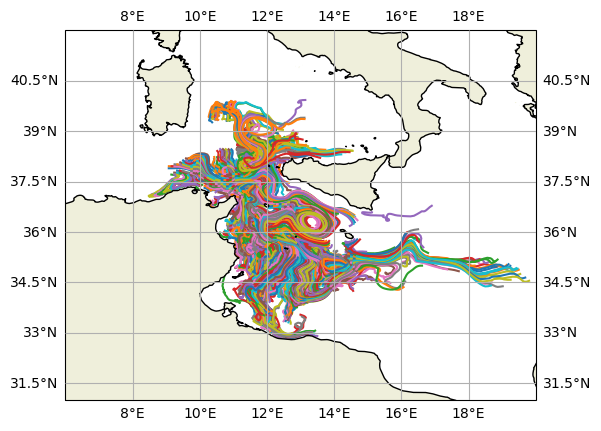

In [12]:
# Plot the trajectories
ds = xr.open_zarr('example_Tunisia_fisheries_prebuilt.zarr')


ax = plt.subplot(111, projection=ccrs.PlateCarree())
ax.plot(ds['lon'].T, ds['lat'].T, transform=ccrs.PlateCarree(), zorder=0)
ax.add_feature(cfeature.LAND, zorder=1)
ax.coastlines(zorder=2)
ax.gridlines(draw_labels=True, zorder=3)
ax.set_extent([6, 20, 31, 42], crs=ccrs.PlateCarree())
plt.show()

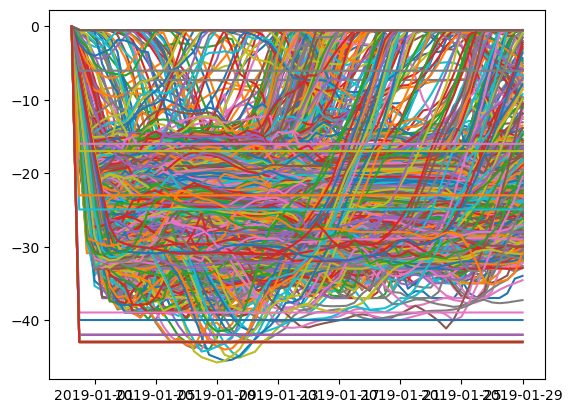

In [13]:
plt.plot(ds['time'].T, -ds['z'].T)
plt.show()

## Implementing your own kernel
In the case you want to include your own kernel or modify an existing kernel, you simply need to define your kernel and include it in the list of kernels. More details on how this works can be found [here](https://docs.oceanparcels.org/en/latest/examples/tutorial_kernelloop.html).

Note: You must include the kernel before the error checking kernels, which are currently the last five kernels.

In [14]:
# An example kernel that applies a constant northward drift to particles
def NorthwardDrift(particle, fieldset, time):
    # Only apply Northward drift if the particle is moving in the ocean
    (ocean_u, ocean_v) = fieldset.UV[time, particle.depth, particle.lat, particle.lon]
    if math.sqrt(ocean_u**2 + ocean_v**2) > 1e-10:
        particle_dlat += 1e-3 # Units of degrees

def EastwardDrift(particle, fieldset, time):
    # Only apply Eastward drift if the particle is moving in the ocean
    (ocean_U, ocean_V) = fieldset.UV[time, particle.depth, particle.lat, particle.lon]
    if math.sqrt(ocean_U**2 + ocean_V**2) > 1e-10:
        particle_dlon += 1e-3 # Units of degrees

In [15]:
# Create the particleset
pset = pp.constructors.create_particleset_from_map(fieldset, settings)

# Create the applicable kernels to the plastic particles
kernels = pp.constructors.create_kernel(fieldset)

# Print the list fo kernels being applied
for kernel in kernels:
    print(kernel)

<function PolyTEOS10_bsq at 0x7f19fefcb910>
<function AdvectionRK4_3D at 0x7f19ffd2ad40>
<function Biofouling at 0x7f19fefcb880>
<function StokesDrift at 0x7f19fefcb6d0>
<function unbeaching at 0x7f19fefcba30>
<function checkThroughBathymetry at 0x7f19fefcbac0>
<function checkErrorThroughSurface at 0x7f19fefcbbe0>
<function periodicBC at 0x7f19fefcbb50>
<function deleteParticle at 0x7f19fefcbc70>


In [16]:
# Insert our new kernels into the list of kernels, but before the error kernels
kernels.insert(4, NorthwardDrift)
kernels.insert(5, EastwardDrift)

for kernel in kernels:
    print(kernel)

<function PolyTEOS10_bsq at 0x7f19fefcb910>
<function AdvectionRK4_3D at 0x7f19ffd2ad40>
<function Biofouling at 0x7f19fefcb880>
<function StokesDrift at 0x7f19fefcb6d0>
<function NorthwardDrift at 0x7f19d409a4d0>
<function EastwardDrift at 0x7f19d409a440>
<function unbeaching at 0x7f19fefcba30>
<function checkThroughBathymetry at 0x7f19fefcbac0>
<function checkErrorThroughSurface at 0x7f19fefcbbe0>
<function periodicBC at 0x7f19fefcbb50>
<function deleteParticle at 0x7f19fefcbc70>


Execute the simulation.

In [17]:
# Create the particle file where output will be stored
pfile = pp.ParticleFile('example_Tunisia_fisheries_custom.zarr', pset, settings=settings, outputdt=outputdt)

# Execute the simulation
pset.execute(kernels, runtime=runtime, dt=dt, output_file=pfile)

INFO: Output files are stored in example_Tunisia_fisheries_custom.zarr.
100%|██████████| 2592000.0/2592000.0 [19:57<00:00, 2164.59it/s] 


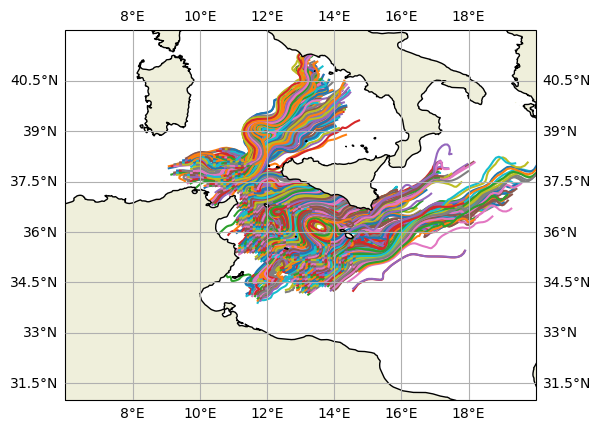

In [18]:
# Plot the trajectories
ds = xr.open_zarr('example_Tunisia_fisheries_custom.zarr')

ax = plt.subplot(111, projection=ccrs.PlateCarree())
ax.plot(ds['lon'].T, ds['lat'].T, transform=ccrs.PlateCarree(), zorder=0)
ax.add_feature(cfeature.LAND, zorder=1)
ax.coastlines(zorder=2)
ax.gridlines(draw_labels=True, zorder=3)
ax.set_extent([6, 20, 31, 42], crs=ccrs.PlateCarree())
plt.show()